In [2]:
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
from numpy import array
import tensorflow as tf
from keras import optimizers
from numpy import expand_dims
from pickle import dump, load
from keras.models import Model
from keras import Input, layers
from keras.layers.merge import add
from readfile import load_vrd_data
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing import sequence
from matplotlib.patches import Rectangle
from keras.applications import InceptionV3
from keras.preprocessing.text import Tokenizer
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.image import img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Embedding


Using TensorFlow backend.


In [0]:
def bboxes(bbox):
  xmin = bbox[2]
  ymin = bbox[0]
  xmax = bbox[3]
  ymax = bbox[1]
  return xmin,ymin,xmax,ymax

In [0]:
df_train, df_valid, df_test = load_vrd_data()

In [5]:
train_img = []
img_filename = "/content/drive/My Drive/visual_relation/sg_train_images/"
for i in range(len(df_train["source_img"])):
   train_img.append(img_filename + df_train["source_img"][i])
print(len(train_img))

val_img = []
for i in range(len(df_valid["source_img"])):
   val_img.append(img_filename + df_valid["source_img"][i])
print(len(val_img))

img_filename2 = "/content/drive/My Drive/visual_relation/sg_test_images/"
test_img = []
for i in range(len(df_test["source_img"])):
  if df_test["source_img"][i] != "4392556686_44d71ff5a0_o.jpg":
    test_img.append(img_filename2 + df_test["source_img"][i])
print(len(test_img))

22847
7508
7632


In [6]:
train_label = to_categorical(df_train["label"], num_classes=70) 

val_label = to_categorical(df_valid["label"], num_classes=70) 

y_test =[]
for i in range(len(df_test["label"])):
  if df_test["source_img"][i] != "4392556686_44d71ff5a0_o.jpg":
    y_test.append(df_test["label"][i])

test_label = to_categorical(y_test, num_classes=70) 
print(len(test_label))

7632


In [7]:
#Train
breach = open("/content/drive/My Drive/visual_relation/train/subject_train.pickle", "rb")
train_subject_features = load(breach)
print('Photos: train=%d' % len(train_subject_features))
breach.close()

breach = open("/content/drive/My Drive/visual_relation/train/object_train.pickle", "rb")
train_object_features = load(breach)
print('Photos: train=%d' % len(train_object_features))
breach.close()

breach = open("/content/drive/My Drive/visual_relation/train/predicate_train.pickle", "rb")
train_predicate_features = load(breach)
print('Photos: train=%d' % len(train_predicate_features))
breach.close()

Photos: train=22847
Photos: train=22847
Photos: train=22847


In [8]:
#val
breach = open("/content/drive/My Drive/visual_relation/val/subject_val.pickle", "rb")
val_subject_features = load(breach)
print('Photos: train=%d' % len(val_subject_features))
breach.close()

breach = open("/content/drive/My Drive/visual_relation/val/object_val.pickle", "rb")
val_object_features = load(breach)
print('Photos: train=%d' % len(val_object_features))
breach.close()

breach = open("/content/drive/My Drive/visual_relation/val/predicate_val.pickle", "rb")
val_predicate_features = load(breach)
print('Photos: train=%d' % len(val_predicate_features))
breach.close()

Photos: train=7508
Photos: train=7508
Photos: train=7508


In [9]:
#test
breach = open("/content/drive/My Drive/visual_relation/test/subject_test.pickle", "rb")
test_subject_features = load(breach)
print('Photos: train=%d' % len(test_subject_features))
breach.close()

breach = open("/content/drive/My Drive/visual_relation/test/object_test.pickle", "rb")
test_object_features = load(breach)
print('Photos: train=%d' % len(test_object_features))
breach.close()

breach = open("/content/drive/My Drive/visual_relation/test/predicate_test.pickle", "rb")
test_predicate_features = load(breach)
print('Photos: train=%d' % len(test_predicate_features))
breach.close()

Photos: train=7632
Photos: train=7632
Photos: train=7632


In [10]:
def to_vocabulary(descriptions):
	all_desc = set()
	for key in range(len(descriptions)):
		all_desc.update(descriptions[key].split())
	return all_desc

train_vocabulary = to_vocabulary(df_train["sent"])
val_vocabulary = to_vocabulary(df_valid["sent"])

print('Original Train Vocabulary Size: %d' % len(train_vocabulary))
print (train_vocabulary)
print('Original Valid Vocabulary Size: %d' % len(val_vocabulary))
print (val_vocabulary)

Original Train Vocabulary Size: 61
{'lean', 'lying', 'has', 'under', 'beside', 'park', 'the', 'beneath', 'by', 'top', 'face', 'feed', 'to', 'fly', 'behind', 'above', 'near', 'pull', 'rest', 'stand', 'sit', 'left', 'cover', 'look', 'wear', 'of', 'against', 'eat', 'attach', 'outside', 'inside', 'adjacent', 'ride', 'in', 'at', 'kick', 'below', 'across', 'taller', 'past', 'than', 'use', 'touch', 'contain', 'sleep', 'drive', 'with', 'watch', 'follow', 'front', 'hit', 'next', 'right', 'over', 'play', 'skate', 'carry', 'walk', 'on', 'hold', 'talk'}
Original Valid Vocabulary Size: 59
{'lean', 'lying', 'has', 'under', 'beside', 'park', 'the', 'beneath', 'by', 'top', 'face', 'to', 'fly', 'behind', 'above', 'near', 'pull', 'rest', 'stand', 'sit', 'left', 'cover', 'look', 'wear', 'of', 'against', 'eat', 'attach', 'outside', 'inside', 'adjacent', 'ride', 'in', 'at', 'taller', 'past', 'below', 'across', 'than', 'use', 'touch', 'contain', 'drive', 'sleep', 'with', 'watch', 'follow', 'front', 'hit', '

In [11]:
train_descriptions = []
for i in range(len(df_train["label"])):
  train_descriptions.append('startseq ' + df_train["sent"][i] + ' endseq')
print(len(train_descriptions))

22847


In [12]:
val_descriptions = []
for i in range(len(df_valid["label"])):
  val_descriptions.append('startseq ' + df_valid["sent"][i] + ' endseq')
len(val_descriptions)

7508

In [35]:
test_descriptions = []
for i in range(len(df_test["label"])):
  test_descriptions.append('startseq ' + df_test["sent"][i] + ' endseq')
len(test_descriptions)

7638

In [13]:
# Consider only words which occur at least 1 times in the corpus
word_count_threshold = 1
word_counts = {}
nsents = 0
for sent in train_descriptions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 63 -> 63


In [0]:
#Create word to index and index to word
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [15]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

64

In [16]:
# calculate the length of the description with the most words
def max_length(descriptions):
	return max(len(d.split()) for d in descriptions)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 6


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, subjects,objects, wordtoix, max_length, num_photos_per_batch):
  X1, X2, X3, y = list(), list(), list(), list()
  n=0
  # loop for ever over images
  while 1:
    for k in range(len(descriptions)):
      n+=1
      # retrieve the photo feature
      sub = subjects[k] 
      obj = objects[k]
      #for desc in descriptions:
      # encode the sequence
      seq = [wordtoix[word] for word in descriptions[k].split(' ') if word in wordtoix]
      # split one sequence into multiple X, y pairs
      for i in range(1, len(seq)):
        # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        X1.append(sub)
        X2.append(obj)
        X3.append(in_seq)
        y.append(out_seq)
      # yield the batch data
      if n==num_photos_per_batch:
        yield [[array(X1), array(X2), array(X3)], array(y)]
        X1, X2, X3, y = list(), list(), list(), list()
        n=0

In [18]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(2048,))
fe3 = Dropout(0.5)(inputs2)
fe4 = Dense(256, activation='relu')(fe3)

inputs3 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs3)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, fe4, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
model.summary()


In [0]:
model.layers[3].set_weights([embedding_matrix])
model.layers[3].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
epochs = 5
number_pics_per_bath = 12
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
#Train model on training and optimize hyperparameter on validation dataset
for i in range(epochs):
    generator_train = data_generator(train_descriptions, train_subject_features, train_object_features, wordtoix, max_length, number_pics_per_bath)
    generator_val = data_generator(val_descriptions, val_subject_features, val_object_features, wordtoix, max_length, number_pics_per_bath) 
    model.fit_generator(generator_train, epochs=1, steps_per_epoch=steps, verbose=1, validation_data= generator_val,validation_steps=steps)

In [36]:
#Evaluate on test data
generator = data_generator(test_descriptions, test_subject_features, test_object_features, wordtoix, max_length, number_pics_per_bath)
model.evaluate_generator(generator, steps = 12)

[1.0713322162628174, 0.7321937084197998]

In [0]:
def greedySearch(sub,obj):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([sub,obj,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

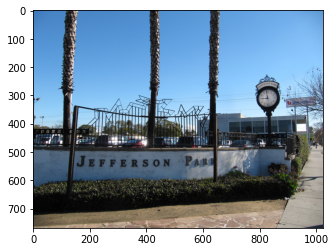

Predicted : on
Actual :on
Sentence (Subject + Predicate + Object) :clock on post


In [40]:
q= 0
#pic = list(encoding_test.keys())[z]
sub = test_subject_features[q].reshape((1,2048))
obj = test_object_features[q].reshape((1,2048))
x=plt.imread(test_img[q])
plt.imshow(x)
plt.show()
print("Predicted : " + greedySearch(sub,obj))
print("Actual :" + df_test["sent"][q])
print("Sentence (Subject + Predicate + Object) :" + df_test["subject_category"][q] + " " + df_test["sent"][q] + " " + df_test["object_category"][q])
